In [22]:
import torch
import torch.nn as nn # 신경망들이 포함됨
import torch.nn.functional as F
import torch.optim as optim # 최적화 알고리즘들이 포함됨
import torch.nn.init as init # 텐서에 초기값을 줌


#import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴

import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

from torchvision import datasets, transforms, models  # models 임포트 추가

!pip install datasets
# 데이터셋 불러오기
from datasets import load_dataset

In [23]:
# DOCCI 데이터셋 로드 -> 대신에 옥스포드 펫으로 모의 테스트
ds = load_dataset('pcuenq/oxford-pets')  # DOCCI 데이터셋 경로에 맞게 변경

In [24]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## CNN

In [25]:
#import torch.nn as nn
#import torch.nn.functional as F

# Bottleneck Block used in ResNet-50
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = F.relu(out)

        return out


class ResNetEncoder(nn.Module):
    def __init__(self, block, layers):
        super(ResNetEncoder, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # 벡터화하여 출력

        return x

# Instantiate modified ResNet encoder
def ResNet50Encoder():
    return ResNetEncoder(Bottleneck, [3, 4, 6, 3])


## 데이터 전처리

In [26]:
# 데이터셋에 전처리 적용
train_dataset = ds['train'].map(preprocess)

# 전처리된 데이터셋 확인
print(train_dataset[0])  # 전처리된 첫 번째 요소 출력


Output hidden; open in https://colab.research.google.com to view.

데이터 셋 분리 과정. 6:2:2 로 분리했음

In [27]:
print(ds)

# 학습 데이터셋 분리
train_val_dataset = ds['train'].train_test_split(test_size=0.4)  # 60%를 학습, 40%를 검증+테스트

# 검증과 테스트 데이터셋 분리
val_test_dataset = train_val_dataset['test'].train_test_split(test_size=0.5)  # 50%를 검증, 50%를 테스트

# 최종 데이터셋 구성
train_dataset = train_val_dataset['train']
val_dataset = val_test_dataset['train']
test_dataset = val_test_dataset['test']
print()
print(ds['train'].column_names)
print()
print(ds['train'].features)
# 결과 확인

print(train_dataset)
print(val_dataset)
print(test_dataset)
#plt.imshow(train_dataset['image'][0])



DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 7390
    })
})

['path', 'label', 'dog', 'image']

{'path': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None), 'dog': Value(dtype='bool', id=None), 'image': {'bytes': Value(dtype='binary', id=None), 'path': Value(dtype='string', id=None)}}
Dataset({
    features: ['path', 'label', 'dog', 'image'],
    num_rows: 4434
})
Dataset({
    features: ['path', 'label', 'dog', 'image'],
    num_rows: 1478
})
Dataset({
    features: ['path', 'label', 'dog', 'image'],
    num_rows: 1478
})


### CNN에 사용할 데이터셋 전처리

In [28]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch

# 이미지 전처리: 크기 조정 및 텐서 변환
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   # 이미지 크기 조정
    transforms.ToTensor(),           # 이미지를 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 정규화
])

# 데이터셋에서 이미지와 레이블 추출하여 CNN에 맞게 변환
class DogImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        image = image['image_data'] #  Extract the PIL Image from the dictionary

        image = self.image_transform(image)

        label = self.dataset[idx]['label']
        image = self.transform(image) if self.transform else image
        return image, label

# DataLoader 설정
train_loader = DataLoader(DogImageDataset(train_dataset, image_transforms), batch_size=32, shuffle=True)
val_loader = DataLoader(DogImageDataset(val_dataset, image_transforms), batch_size=32)
test_loader = DataLoader(DogImageDataset(test_dataset, image_transforms), batch_size=32)


###Transformer 에 쓸 데이터 전처리

In [29]:
from transformers import AutoTokenizer

# Pre-trained tokenizer 사용 (예: BERT)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# 텍스트 데이터를 Transformer 모델에 맞게 변환
class DogTextDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer, max_length=77):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]['label']
        encoded = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        return encoded['input_ids'].squeeze(), encoded['attention_mask'].squeeze()

# DataLoader 설정
train_text_loader = DataLoader(DogTextDataset(train_dataset, tokenizer), batch_size=32, shuffle=True)
val_text_loader = DataLoader(DogTextDataset(val_dataset, tokenizer), batch_size=32)
test_text_loader = DataLoader(DogTextDataset(test_dataset, tokenizer), batch_size=32)


### 전처리한 데이터들 통합

In [30]:
class DogImageTextDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, image_transform, tokenizer, max_length=77):
        self.dataset = dataset
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        text = self.dataset[idx]['label']
        image = self.image_transform(image)

        encoded = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoded['input_ids'].squeeze()
        attention_mask = encoded['attention_mask'].squeeze()

        return image, input_ids, attention_mask

# DataLoader 설정
train_combined_loader = DataLoader(
    DogImageTextDataset(train_dataset, image_transforms, tokenizer),
    batch_size=32, shuffle=True
)
val_combined_loader = DataLoader(
    DogImageTextDataset(val_dataset, image_transforms, tokenizer),
    batch_size=32
)
test_combined_loader = DataLoader(
    DogImageTextDataset(test_dataset, image_transforms, tokenizer),
    batch_size=32
)


건들지말기. 데이터셋 확인겸 이미지 띄워본거임.

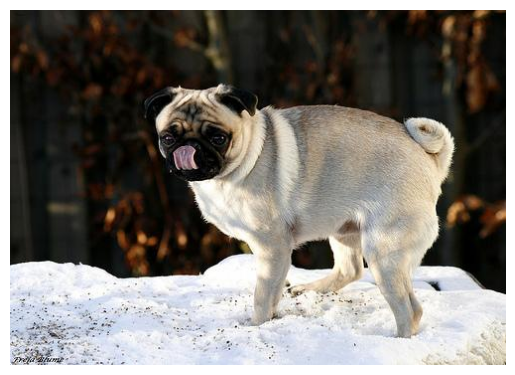

/data/datasets/magic-ml/oxford-iiit-pet/images/pug_70.jpg
pug
True


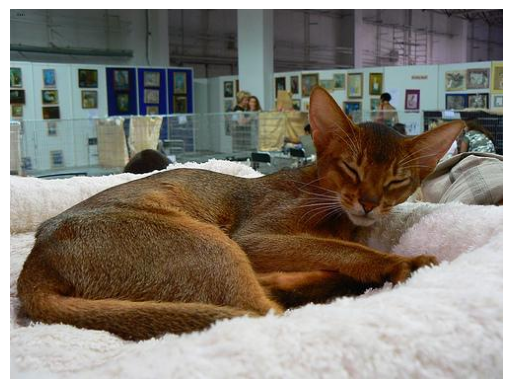

/data/datasets/magic-ml/oxford-iiit-pet/images/Abyssinian_148.jpg
Abyssinian
False


In [31]:

from PIL import Image
import io

# 1,2 번째 이미지의 경로 또는 바이트 데이터 가져오기
for i in range(2):
  image_data = train_dataset['image'][i]['bytes']  # 바이너리 형식으로 가져오기

  # 이미지 데이터에서 PIL 이미지로 변환
  img = Image.open(io.BytesIO(image_data))

  # 이미지 출력
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  print(train_dataset['path'][i])
  print(train_dataset['label'][i])
  print(train_dataset['dog'][i])

In [32]:
# 이미지 변환 설정 (ResNet-50 용)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),      # ResNet50 입력 크기
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image):
    image = Image.open(image).convert("RGB")  # 이미지 파일 열기
    return image_transforms(image)  # 전처리 후 반환


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 기본 Residual Block 정의
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet-50 구현
class ResNet50(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet50, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet Layers
        self.layer1 = self._make_layer(64, 3, stride=1)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 6, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


## Transformer

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0  # d_model이 num_heads로 나누어 떨어져야 함
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        # Linear projections
        q = self.linear_q(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.linear_k(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.linear_v(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention = F.softmax(scores, dim=-1)
        output = torch.matmul(attention, v)

        # Concatenate heads and pass through the final linear layer
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.linear_out(output)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.attention(x, x, x, mask)
        x = self.layer_norm1(x + self.dropout1(attn_output))
        ff_output = self.feed_forward(x)
        return self.layer_norm2(x + self.dropout2(ff_output))

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, vocab_size, max_length=77, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)  # 텍스트 임베딩
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_length, d_model))  # Positional encoding
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids) + self.positional_encoding[:, :input_ids.size(1), :]
        for layer in self.layers:
            x = layer(x, attention_mask)
        x = x.mean(dim=1)  # 문장의 평균 벡터를 반환
        return x



class TransformerTextEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, max_len=512, dropout=0.1):
        super(TransformerTextEncoder, self).__init__()
        self.d_model = d_model
        self.token_embedding = nn.Embedding(vocab_size, d_model)

        # 포지셔널 인코딩
        self.pos_embedding = nn.Parameter(torch.zeros(1, max_len, d_model))
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # 임베딩 레이어 및 포지셔널 인코딩 추가
        x = self.token_embedding(x) * math.sqrt(self.d_model)
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.dropout(x)

        # Transformer 인코더 레이어들을 통과
        for layer in self.layers:
            x = layer(x, mask)

        # 마지막 출력을 평균하여 문장 임베딩 생성
        x = x.mean(dim=1)
        x = F.normalize(x, p=2, dim=1)  # 정규화하여 반환

        return x


## CLIP

In [35]:
class CLIPModel(nn.Module):
    def __init__(self, cnn_model, transformer_model, embed_dim=512):
        super(CLIPModel, self).__init__()
        self.cnn_model = cnn_model
        self.transformer_model = transformer_model
        self.image_projection = nn.Linear(2048, embed_dim)  # ResNet50 output dimension to embed_dim
        self.text_projection = nn.Linear(transformer_model.embedding.embedding_dim, embed_dim)

    def forward(self, image, input_ids, attention_mask):
        image_features = self.cnn_model(image)  # 이미지에서 벡터 생성
        text_features = self.transformer_model(input_ids, attention_mask)  # 텍스트에서 벡터 생성

        # 벡터를 공통 임베딩 공간으로 투영
        image_embed = self.image_projection(image_features)
        text_embed = self.text_projection(text_features)

        # 코사인 유사도를 계산하여 반환
        image_embed = F.normalize(image_embed, dim=-1)
        text_embed = F.normalize(text_embed, dim=-1)
        similarity = torch.matmul(image_embed, text_embed.T)
        return similarity


##학습 (동작안함. 데이터전처리 이상함)

In [36]:
# Example usage with data loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clip_model = CLIPModel(ResNet50Encoder(), TransformerEncoder(num_layers=6, d_model=512, num_heads=8, d_ff=2048, vocab_size=30522)).to(device)

for image, input_ids, attention_mask in train_combined_loader:
    image = image.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    similarity = clip_model(image, input_ids, attention_mask)
    print("Image-Text Similarity:", similarity)


TypeError: Unexpected type <class 'dict'>